In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from keras.applications import ResNet50
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import os


In [2]:
# Load data
X_train = []
Y_train = []
image_size = 150
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']


In [3]:


for i in labels:
    folderPath = os.path.join('./Training', i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(i)

for i in labels:
    folderPath = os.path.join('./Testing', i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(i)



In [4]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train, Y_train = shuffle(X_train, Y_train, random_state=101)





In [5]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=101)


In [6]:
# Convert labels to categorical
y_train = tf.keras.utils.to_categorical([labels.index(i) for i in y_train])
y_test = tf.keras.utils.to_categorical([labels.index(i) for i in y_test])




In [7]:
# Load pre-trained ResNet50 model without top (fully connected) layers
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))


94765736/94765736 [==============================] - 29s 0us/step


In [8]:
# Freeze the convolutional base
for layer in resnet_base.layers:
    layer.trainable = False



In [9]:
# Add custom top layers for classification
model = Sequential([
    resnet_base,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])



In [10]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 2

In [11]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])



C:\Anaconda\envs\myenv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)



Epoch 1/20
75/75 [==============================] - 19s 106ms/step - loss: 1.2746 - accuracy: 0.6492 - val_loss: 0.4141 - val_accuracy: 0.8459
Epoch 2/20
75/75 [==============================] - 5s 71ms/step - loss: 0.4633 - accuracy: 0.8303 - val_loss: 0.3194 - val_accuracy: 0.8684
Epoch 3/20
75/75 [==============================] - 5s 71ms/step - loss: 0.3074 - accuracy: 0.8889 - val_loss: 0.3112 - val_accuracy: 0.8797
Epoch 4/20
75/75 [==============================] - 5s 71ms/step - loss: 0.2054 - accuracy: 0.9237 - val_loss: 0.2526 - val_accuracy: 0.9173
Epoch 5/20
75/75 [==============================] - 5s 71ms/step - loss: 0.1617 - accuracy: 0.9392 - val_loss: 0.2770 - val_accuracy: 0.8872
Epoch 6/20
75/75 [==============================] - 5s 71ms/step - loss: 0.1082 - accuracy: 0.9631 - val_loss: 0.2648 - val_accuracy: 0.9211
Epoch 7/20
75/75 [==============================] - 5s 72ms/step - loss: 0.0850 - accuracy: 0.9719 - val_loss: 0.3037 - val_accuracy: 0.9135
Epoch 8/20


In [13]:

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

10/10 [==============================] - 1s 66ms/step - loss: 0.3402 - accuracy: 0.9186
Test Accuracy: 0.9186440706253052


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

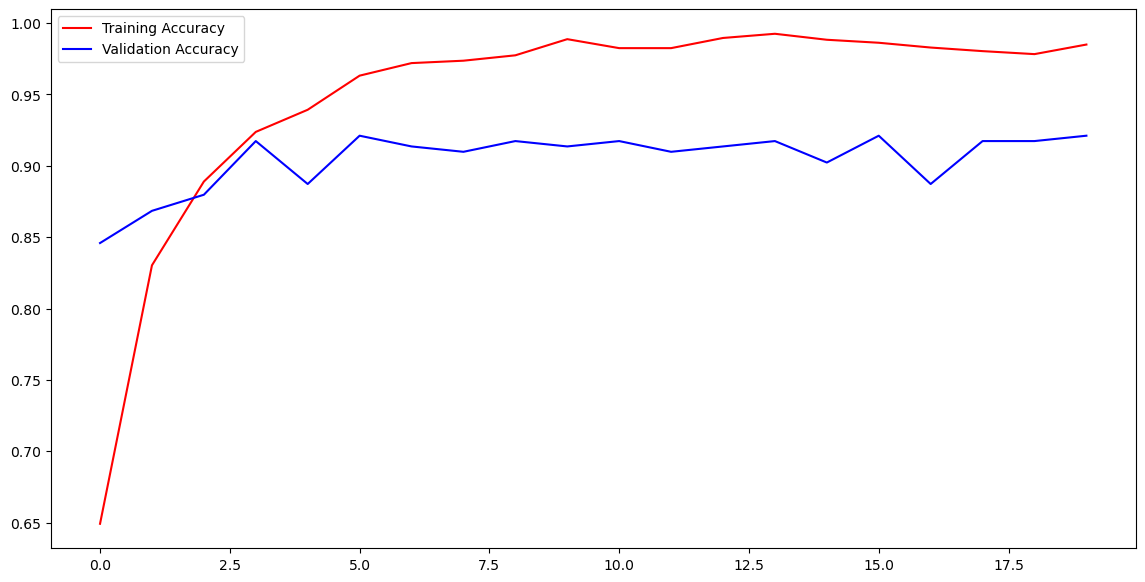

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
plt.legend(loc="upper left")
plt.show()

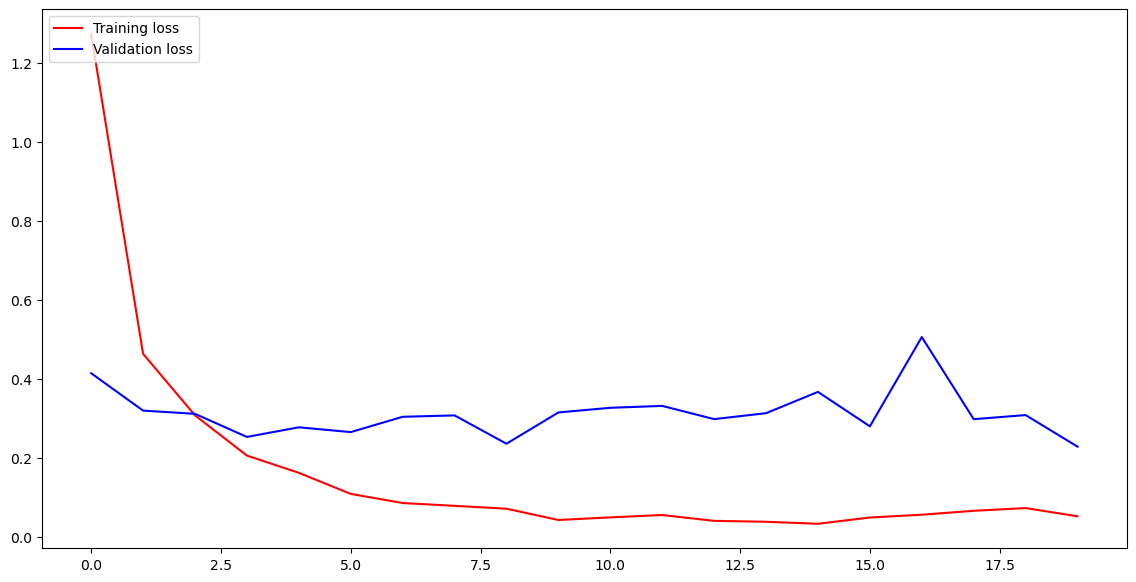

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.legend(loc="upper left")
plt.show()

In [ ]:
model.save('braintumorResNet50.h5')